# Support Vector Machine Exercise
In this exercise you will learn about:
1. Implementing SVM from scratch using a sub-gradient method called Pegasos (2011)
2. The effect of imbalance and non-seperable classes on the SVM solution.
3. Pratical SVM in scikit-learn on a simple example including hyper parameter optimization wrapper class to find optimal regularization, loss and multiclass technique.
4. Optional reading material on one class, new probability interpretation of SVM

## 1. Implementing the PEGASOS SVM (55 points)
We will implement the simplest SVM implementation. 
It is based on a paper by Shalev-Shwartz et al (see reading material below).
The essense of the algorithm is copied below from the paper:
![alt text](https://snag.gy/Gpi1Mk.jpg)

Here is a little more deailed explanation (it's recommended to read the full paper).
![alt_text](https://snag.gy/koA0ue.jpg)


1. Implement a class *PegasosSVM* which has parameter $\lambda$ and $T$ and methods *fit* and *predict* and *decision_function* where the latter is the distance from the plane (aka model's output score).
  * **although the above**, here you are required to pad the samples with 1, and not use bias (the separating hyperplane must go through the origin).
  * don't forget labels should be {-1,1} - change them if it is {0,1}
  * don't forget to normalize your features. You can use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to create a pipeline which first standartize features and then learn.

2. test your class on the breast cancer database [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), and compare your results to the Native Scikit-learn implementation [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
  * you can use [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

3. Analyze the effect of the hyper parameter $\lambda$ on your training and test error. 
  * you can use scikit-learn's `validation_curve`

4. Analyze the learning curve (performance as function of training size)
  * you can use scikit-learn's `learning_curve`

5. *Bonus: Mini-batches* . In the paper, the authors summed the loss over several samples before updating. Extend your class to support mini-batches and analyze the perfomance effect if exists. See more details below

![](https://i.ibb.co/0BGwVz7/1.png)

In [2]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class PegasosSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, lambda_param=None, n_iterations=None):
        self.lambda_param = lambda_param
        self.n_iterations = n_iterations
    
    def pad(self, X):
        x0 = np.ones(X.shape[0])
        x0 = np.matrix(x0).T
        X = np.concatenate((x0, X), axis=1)
        return X
    
    def convert_labels(self, y):
        converted_y = y.copy()
        converted_y[converted_y==0] = -1
        return converted_y
        
    def fit(self, X, y):
        self.X_train = self.pad(X)
        self.y_train = y
        self.converted_y = self.convert_labels(y)
        self.weights = np.zeros(self.X_train.shape[1]) #with weight to pad
        
        for t in range(self.n_iterations):
            step = 1/(self.lambda_param * (t+1)) #define the step size (Start from big steps to small once)
            i = np.random.choice(self.X_train.shape[0], replace=True)
            xi = np.asarray(self.X_train[i]).reshape(-1)
            yi = self.converted_y[i]
            self.decision_function(xi, yi, step)
            
    def decision_function(self, xi, yi, step):
        wx = np.dot(xi, self.weights)
        if yi*wx < 1: #wrong prediction
            self.weights = (1 - step*self.lambda_param)*self.weights + step*yi*xi #add the error
        else:
            self.weights = (1 - step*self.lambda_param)*self.weights
            
    def predict(self, X):
        X_pad = self.pad(X)
        linear_y = np.dot(X_pad, self.weights).reshape(-1,1)
        y_predicts = np.where(linear_y > 0, 1, 0)
        return y_predicts

#### compare your results to the Native Scikit-learn implementation LinearSVC you can use cross_val_score

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

X,y = load_breast_cancer(return_X_y=True)
#create pegasos with n_iteration as "max iterations" in linearsvc
pipe_pegasosSVM = Pipeline([('scaler', StandardScaler()),('pegasossvm', PegasosSVM(lambda_param=0.1, 
                                                                                   n_iterations=1000))]) 
pipe_nativeSVM = Pipeline([('scaler', StandardScaler()), ('linearsvc', LinearSVC())])

In [3]:
pegasosSVM_scores = cross_val_score(pipe_pegasosSVM, X, y, cv=5, scoring='accuracy')
nativeSVM_scores = cross_val_score(pipe_nativeSVM, X, y, cv=5, scoring='accuracy')
print(f"pegasos svm scores: {pegasosSVM_scores}")
print(f"pegasos svm mean score: {pegasosSVM_scores.mean()}")
print(f"naive svm scores: {nativeSVM_scores}")
print(f"naive svm mean score: {nativeSVM_scores.mean()}")

pegasos svm scores: [0.97368421 0.94736842 0.97368421 0.96491228 0.98230088]
pegasos svm mean score: 0.968390001552554
naive svm scores: [0.94736842 0.95614035 0.95614035 0.98245614 0.99115044]
naive svm mean score: 0.9666511411271541


#### Analyze the effect of the hyper parameter  𝜆  on your training and test error.

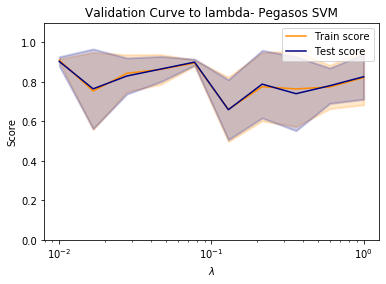

In [20]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

param_range = np.logspace(-2, 0, 10)
train_scores, test_scores = validation_curve(PegasosSVM(lambda_param = None, n_iterations=1000), 
                                             X, y, param_name="lambda_param", param_range=param_range, n_jobs=2)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve to lambda- Pegasos SVM")
plt.xlabel(r"$\lambda$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Train score", color="darkorange")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
    alpha=0.2, color="darkorange",lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Test score", color="navy")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
    alpha=0.2, color="navy",lw=lw)
plt.legend(loc="best")
plt.show()

As we can see from the validation curve the test and train scores are pretty similar all over the graph, which means we are not tend to overfitting. In addition, the best score is around ~=0.85 which it's a good score and it's not tend to underfitting. When the lambda param is too low or too high the accuracy decreases. So we got that the best lambda is around ~=0.08.
We can see that the margines are very wide and that's because they are calculated from mean with std and because the algorithem has random calculation inside it, the std is not so low.

#### Analyze the learning curve (performance as function of training size)

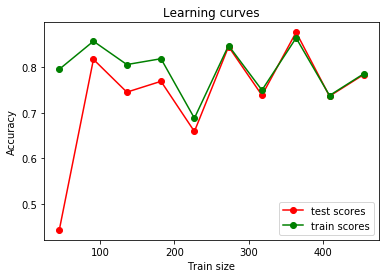

In [24]:
from sklearn.model_selection import learning_curve

clf = PegasosSVM(lambda_param = 0.2, n_iterations=1000)
train_sizes, train_scores, test_scores = learning_curve(clf, X, y, train_sizes=np.linspace(0.1, 1, 10),cv=5)

plt.plot(train_sizes, np.mean(test_scores, axis=1), "o-", color="r", label="test scores")
plt.plot(train_sizes, np.mean(train_scores, axis=1), "o-", color="g", label="train scores")
plt.xlabel("Train size")
plt.ylabel("Accuracy")
plt.title("Learning curves")
plt.legend(loc="best")
plt.show()

As we can see from the graph, the best train size is around 350 samples.
Probably when we use more samples we starts to tend to overfitting on train and when we use less samples we are underfitting the model.

## 2. The importance of class weighting in SVM (15)
When classes are imbalance and not seperable, SVM might result in non intuitive solution.

To see this create a function `make_data` which generates a two dimensional dataset with `n_samples=1000` where a fraction `imbalance=0.1` is labeled `0` and the rest `1`. The distribution of $x$ given $y=0$ or $y=1$ is gaussian with std 0.5 or 2, respectively and that the centers are at $x_1=0$ and $x_2=-d/2$ and $x_2=d/2$, respectively. In other words,  
$$
p(x|y) = \mathcal{N}(\mu=(±d/2,0),\,\sigma=1/2+3/2\times y)
$$
and 
$$
p(y=0) = 0.1
$$. 

* For `d=10` and `d=2` plot the scatter plot of the data. Where would you think the SVM hyperplane will lie?

* Now, for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn.

To plot the hyperplane, note that the fitted model has the `coef_` and `intercept_` properties.
Add also the `accuracy` and the `balanced_accuracy` metrics to the plot title.

* repeat the experiment but now set the `class_weight` to be `balanced`. 

Explain what was the problem and how changing class weight solved it.


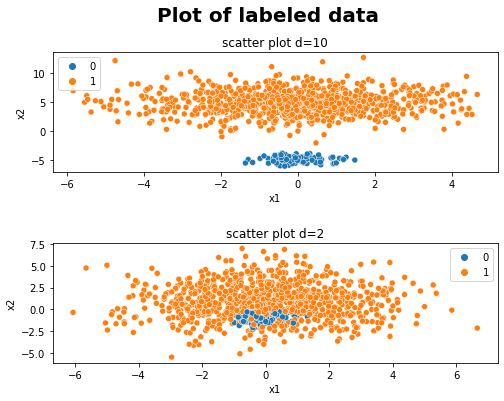

In [43]:
import seaborn as sns

def make_data(d):
    n_samples=1000
    y_samples = np.random.binomial(n=1, p=0.9, size=n_samples)
    x_samples = np.empty((n_samples,2))
    mu1 = 0
    
    for i in range(n_samples-1):
        if y_samples[i] == 0:
            sigma = 0.5
            mu2 = -d/2
        else:
            sigma = 2
            mu2 = d/2 
            
        x_samples[i] = [np.random.normal(mu1, sigma), np.random.normal(mu2, sigma)]
    return x_samples, y_samples
    
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
fig.tight_layout(pad=5.0)
fig.suptitle('Plot of labeled data',fontsize=20, fontweight ="bold")

x_samples_d10, y_samples_d10 = make_data(10)
ax1 = sns.scatterplot(ax=axes[0], x=x_samples_d10[:, 0], y=x_samples_d10[:, 1], hue=y_samples_d10)
ax1.set(xlabel= 'x1', ylabel='x2', title="scatter plot d=10")

x_samples_d2, y_samples_d2 = make_data(2)
ax2 = sns.scatterplot(ax=axes[1],x=x_samples_d2[:, 0], y=x_samples_d2[:, 1], hue=y_samples_d2)
ax2.set(xlabel= 'x1', ylabel='x2', title="scatter plot d=2")

plt.show()

#### Where would you think the SVM hyperplane will lie?

On d=10 the svm hyperplane will be on x2~= -2.5 which it's between the 2 classes and with the maximum width for the margine. On d=2 it's harder to say, it might take some wrong samples and will try to create linear line from the origine.

#### Now, for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn

In [44]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

def svm_info(model, y_predict, y_true):
    weights = model.coef_[0]
    intercept = model.intercept_
    accuracy = accuracy_score(y_predict, y_true)
    balanced_accuracy = round(balanced_accuracy_score(y_predict, y_true),4)
    return weights, intercept, accuracy, balanced_accuracy

In [46]:
pipe_linearSVM = Pipeline([('scaler', StandardScaler()), ('linearsvc', LinearSVC())])
pipe_linearSVM.fit(x_samples_d10, y_samples_d10)
y_peredict_d10 = pipe_linearSVM['linearsvc'].predict(x_samples_d10)
d10_w, d10_inter, d10_acc, d10_accb = svm_info(pipe_linearSVM['linearsvc'], y_peredict_d10, y_samples_d10)       
print(f'SVM d=10 weights: {d10_w}, intercept: {d10_inter}')

pipe_linearSVM2 = Pipeline([('scaler', StandardScaler()), ('linearsvc', LinearSVC())])
pipe_linearSVM2.fit(x_samples_d2, y_samples_d2)
y_peredict_d2 = pipe_linearSVM['linearsvc'].predict(x_samples_d2)
d2_w, d2_inter, d2_acc, d2_accb = svm_info(pipe_linearSVM2['linearsvc'], y_peredict_d2, y_samples_d2)
print(f'SVM d=2 weights: {d2_w}, intercept: {d2_inter}')

SVM d=10 weights: [-0.02706071  1.41494608], intercept: [2.34987954]
SVM d=2 weights: [-0.00038422  0.23830825], intercept: [0.84580495]


#### repeat the experiment but now set the class_weight to be balanced.

In [47]:
pipe_linearSVM_balaced = Pipeline([('scaler', StandardScaler()),('linearsvc',LinearSVC(class_weight='balanced'))])
pipe_linearSVM_balaced.fit(x_samples_d10, y_samples_d10)
y_peredictb_d10 = pipe_linearSVM_balaced['linearsvc'].predict(x_samples_d10)
d10_b_w, d10_b_inter, d10_b_acc, d10_b_accb = svm_info(pipe_linearSVM_balaced['linearsvc'], 
                                                       y_peredictb_d10, y_samples_d10)       
print(f'SVM d=10 weights: {d10_b_w}, intercept: {d10_b_inter}')


pipe_linearSVM2_balanced = Pipeline([('scaler', StandardScaler()),('linearsvc',LinearSVC(class_weight='balanced'))])
pipe_linearSVM2_balanced.fit(x_samples_d2, y_samples_d2)
y_peredictb_d2 = pipe_linearSVM2_balanced['linearsvc'].predict(x_samples_d2)
d2_b_w, d2_b_inter, d2_b_acc, d2_b_accb = svm_info(pipe_linearSVM2_balanced['linearsvc'], 
                                                       y_peredictb_d2, y_samples_d10)    
print(f'SVM d=2 weights: {d2_b_w}, intercept: {d2_b_inter}')

SVM d=10 weights: [-0.05002685  1.42873567], intercept: [2.22581055]
SVM d=2 weights: [-0.00510564  0.81110872], intercept: [0.37695604]


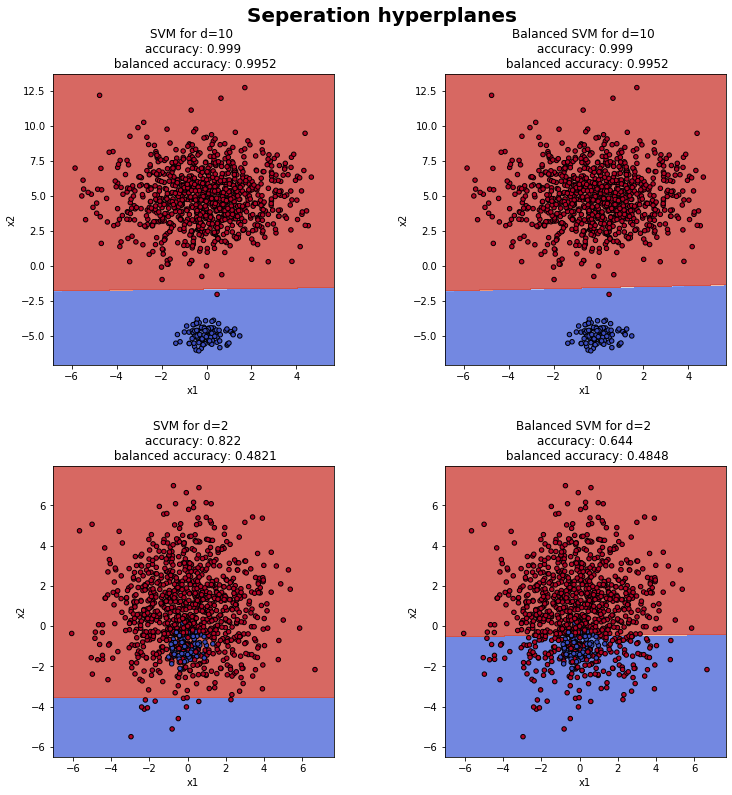

In [49]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.tight_layout(pad=8.0)
fig.suptitle('Seperation hyperplanes',fontsize=20, fontweight ="bold")

# Set-up grid for plotting.
X0, X1 = x_samples_d10[:, 0], x_samples_d10[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(axes[0,0], pipe_linearSVM['linearsvc'], xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
axes[0,0].scatter(X0, X1, c=y_samples_d10, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
axes[0,0].set_ylabel('x2')
axes[0,0].set_xlabel('x1')
axes[0,0].set_title(f"SVM for d=10 \n accuracy: {d10_acc} \n balanced accuracy: {d10_accb}")


plot_contours(axes[0,1], pipe_linearSVM_balaced['linearsvc'], xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
axes[0,1].scatter(X0, X1, c=y_samples_d10, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
axes[0,1].set_ylabel('x2')
axes[0,1].set_xlabel('x1')
axes[0,1].set_title(f"Balanced SVM for d=10 \n accuracy: {d10_b_acc} \n balanced accuracy: {d10_b_accb}")

# Set-up grid for plotting.
X0, X1 = x_samples_d2[:, 0], x_samples_d2[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(axes[1,0], pipe_linearSVM2['linearsvc'], xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
axes[1,0].scatter(X0, X1, c=y_samples_d2, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
axes[1,0].set_ylabel('x2')
axes[1,0].set_xlabel('x1')
axes[1,0].set_title(f"SVM for d=2 \n accuracy: {d2_acc} \n balanced accuracy: {d2_accb}")
     

plot_contours(axes[1,1], pipe_linearSVM2_balanced['linearsvc'], xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
axes[1,1].scatter(X0, X1, c=y_samples_d2, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
axes[1,1].set_ylabel('x2')
axes[1,1].set_xlabel('x1')
axes[1,1].set_title(f"Balanced SVM for d=2 \n accuracy: {d2_b_acc} \n balanced accuracy: {d2_b_accb}")

plt.show()

#### Explain what was the problem and how changing class weight solved it.

The problem was on d=2 samples which had 2 classes that mixed together and the svm linear line couldn't separate
them with a good way, no matter what the linear solver had to include in each class points from the other class.
Without the balanced weight we got on d=2 an hyperplane that is far away from the blue dots, this plane only classifier red dots as blue without any blue dot on the right class and that was a problem.
THis problem happend because the red dots are the majority and blue dots has less weight on the model because of that.
When we used balanced class weights we set the parameter C of class i to class_weight_i * C which gave to the blue dots probably more weight when we get wrong with them and leads to create hyperplane that take in account the blue dots and try to splite them in a good manner.

## 3. SVM hyperparameter search (10)
Machine learning pipelines in general and models in particular has several hyperparametrs that we currently do not know how to optimize.
Instead, researcher use grid search or random search techniques to find the optimal hyper parameters.
In this exercise you are requested to compare between default params model and a model which internally optimize for these hyper parameters.
Luckily, scikit-learn already has a ready class for doing that called `GridSearchCV`. Use the latter class to check all the combination of the following hyper parameters:
* `'multi_class':['ovr', 'crammer_singer']`
* `'loss':['hinge', 'squared_hinge']`
* `'C': np.logspace(-3,3,10)`

Compare the accuracy of the model to a default `LinearSVC` model with no hyper parameter optimization in terms of accuracy.

Note: Recall, that hyper parameter search is a learning procedure by itself, thus one should not use test data for the process. 

To do this you can use the handy `cross_val_score` function.


In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from warnings import filterwarnings
filterwarnings('ignore')

X,y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
scaler = StandardScaler()
X_train_normalize = scaler.fit_transform(X_train)
X_test_normalize = scaler.fit_transform(X_test)

gridSVM = GridSearchCV(estimator=LinearSVC(), cv=5, scoring="accuracy", 
                                 param_grid={'multi_class':['ovr', 'crammer_singer'],
                                             'loss':['hinge', 'squared_hinge'], 
                                             'C': np.logspace(-3,3,10)})

gridSVM.fit(X_train_normalize, y_train)
grid_scores = gridSVM.score(X_test_normalize, y_test)


pipe_nativeSVM = Pipeline([('scaler', StandardScaler()), ('linearsvc', LinearSVC())])
nativeSVM_scores = cross_val_score(pipe_nativeSVM, X, y, cv=5, scoring="accuracy")

print(f'Best params: {gridSVM.best_params_}')
print(f"GridSearch svm scores: {grid_scores}")
print(f"GridSearch svm mean score: {grid_scores.mean()}") 
print(f"Naive svm scores: {nativeSVM_scores}")
print(f"Naive svm mean score: {nativeSVM_scores.mean()}")

Best params: {'C': 0.1, 'loss': 'hinge', 'multi_class': 'crammer_singer'}
GridSearch svm scores: 0.986013986013986
GridSearch svm mean score: 0.986013986013986
Naive svm scores: [0.94736842 0.95614035 0.95614035 0.98245614 0.99115044]
Naive svm mean score: 0.9666511411271541


## 4. Classifying Checkerboard with SVM (20)
In this exercise you will try to choose a kernel for classifying a checkerboard labeled data. 

* Use the `checkboard` function below to generate
your training set (1000 or 2000 samples) and a testing set (as much as you like). As you can see the function generates samples in 2D and label them according to a 3 × 3 checkerboard (obviously linear separation will not do the job here). Python’s scatter in the might come in handy.

* Use SVM to find a good linear separation in high dimensional feature space using the polynomial or the Gaussian (RBF) kernel.    You should evaluate for both models the best parameters to use. Explain how do you evalute each model?
   - For polynomial kernel, estimate which degree to use
   - For RBF, estimate which standard deviation to use
   - For both models, also choose which regularization parameter is best to use
 
* For the best model of each kernel, plot a scatter plot of the training patterns (colored by label) and mark the support vectors as well. Which model would you choose to use in this case?

* In addition, if you are curious, you can try and think of a way to plot the separating hyper-surface (curve in this case), the margin, and the testing set (to check which points are misclassified).

In [5]:
import numpy as np
def checkerboard(n):
    """
    CHECKERBOARD Sample points from a 3x3 checkerboard in 2D
    """
    X = np.random.rand(n,2); # samples dimension N = 2
    l = np.mod(np.ceil(X*3), 2);
    y0 = np.logical_xor(l[:,0], l[:,1])
    y = y0*2-1 # {-1,+1}
    return X, y

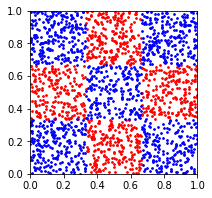

In [6]:
# Usage sample
import matplotlib.pyplot as plt
X, y = checkerboard(2000)
plt.figure(figsize=(3,3))
plt.scatter(X[y==1,0], X[y==1,1], c='r', s=3)
plt.scatter(X[y==-1,0], X[y==-1,1], c='b', s=3)
plt.xlim([0,1])
plt.ylim([0,1]);

In [7]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [51]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    ax.axis("tight")
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z > 0, **params)
    return out

#### Explain how do you evalute each model?

To evaluate each model I will use cross validation on grid search. THe cross validation will help to estimate the param over diffrent groups of data which suppose to make the descition of parameter's value more accurate. We will use accuracy score over each k-fold to evaluate the performance of the model.

#### Polynomial kernel SVM

In [9]:
grid_polySVM = GridSearchCV(estimator=SVC(), scoring="accuracy", 
                            param_grid={'kernel': ["poly"], 
                                        'degree': np.arange(1, 5),
                                        'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 15, 20]})

grid_polySVM.fit(X_train, y_train)
grid_poly_scores = grid_polySVM.score(X_test, y_test)

print(f'Best params: {grid_polySVM.best_params_}')
print(f'Mean accuracy: {grid_poly_scores.mean()}')

Best params: {'C': 1, 'degree': 4, 'kernel': 'poly'}
Mean accuracy: 0.65


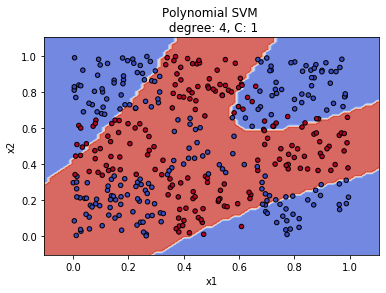

In [52]:
# Set-up grid for plotting.
X0, X1 = X_test[:, 0], X_test[:, 1]
xx, yy = make_meshgrid(X0, X1)

# Put the result into a color plot
plot_contours(plt, grid_polySVM.best_estimator_, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

plt.ylabel('x2')
plt.xlabel('x1')
plt.title(f"Polynomial SVM \n degree: {grid_polySVM.best_params_['degree']}, C: {grid_polySVM.best_params_['C']}")
plt.show()

#### RBF kernel SVM

In [19]:
grid_rbfSVM = GridSearchCV(estimator=SVC(), scoring="accuracy", 
                            param_grid={'kernel': ["rbf"], 
                                        'gamma': [1, 2, 5, 10, 15, 20],
                                        'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 15, 20]})

grid_rbfSVM.fit(X_train, y_train)
grid_rbf_scores = grid_rbfSVM.score(X_test, y_test)

print(f'Best params: {grid_rbfSVM.best_params_}')
print(f'Mean accuracy: {grid_rbf_scores.mean()}')

Best params: {'C': 20, 'gamma': 20, 'kernel': 'rbf'}
Mean accuracy: 0.9825


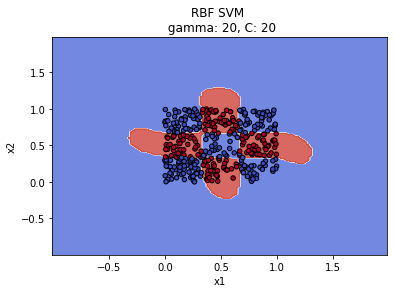

In [55]:
# Set-up grid for plotting.
X0, X1 = X_test[:, 0], X_test[:, 1]
xx, yy = make_meshgrid(X0, X1)

# Put the result into a color plot
plot_contours(plt, grid_rbfSVM.best_estimator_, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

plt.ylabel('x2')
plt.xlabel('x1')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title(f"RBF SVM \n gamma: {grid_rbfSVM.best_params_['gamma']}, C: {grid_rbfSVM.best_params_['C']}")
plt.show()

#### Which model would you choose to use in this case?
The results show us that the rbf model is more accurate then the polynomial model, in addition we can see from the graphs that the rbf model learn the checkerboard shape pretty well so we will choose the rbf model with the best parameters we got: gamma=20, c=20.

## Optional Reading Materials
1. Shalev-Shwartz, S., Singer, Y., Srebro, N., & Cotter, A. (2011). Pegasos: Primal estimated sub-gradient solver for svm. Mathematical programming, 127(1), 3-30. [[pdf](http://www.ee.oulu.fi/research/imag/courses/Vedaldi/ShalevSiSr07.pdf)]

2. Schölkopf, B., Williamson, R. C., Smola, A. J., Shawe-Taylor, J., & Platt, J. C. (2000). Support vector method for novelty detection. In Advances in neural information processing systems (pp. 582-588). [[pdf](http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf)]

3. Livni, R., Crammer, K. & Globerson, A.. (2012). A Simple Geometric Interpretation of SVM using Stochastic Adversaries. Proceedings of the Fifteenth International Conference on Artificial Intelligence and Statistics, in PMLR 22:722-730. [[pdf](http://proceedings.mlr.press/v22/livni12/livni12.pdf)]

